# End to end Model - Training

### Pulkit Mathur, Vaibhav Saxena, Sumeet Ranka, Duc Thong

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sys
import end_to_end_network as etem
import pickle
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import  Adam
from scipy import ndimage

In [8]:
def imagetokspace(image):
    s = image.shape
    kspace = np.zeros((s[0],s[1],2))
    temp = np.fft.fft2(image[:,:,0])
    kspace[:,:,0] = temp.real
    kspace[:,:,1] = temp.imag
    return kspace

## Loading Data

In [9]:
#validation data
with (open('Xvalidation.pickle', "rb")) as openfile:
    mi_val = np.abs(pickle.load(openfile))

mk_val = np.zeros((mi_val.shape[0],320,320,2))
for i in range(mi_val.shape[0]):
    mk_val[i,:,:,:] = imagetokspace(mi_val[i])

mi_val = None

In [10]:
with (open('Yvalidation.pickle', "rb")) as openfile:
    oi_val = np.abs(pickle.load(openfile))

ok_val = np.zeros((oi_val.shape[0],320,320,2))
for i in range(oi_val.shape[0]):
    ok_val[i,:,:,:] = imagetokspace(oi_val[i])

In [11]:
# training data
with (open('Xtraining.pickle', "rb")) as openfile:
    x_train = pickle.load(openfile)

with (open('Ytraining.pickle', "rb")) as openfile:
    y_train = pickle.load(openfile)

## Loading stats

In [5]:
stats = np.load("training_data_stats20.npy")
# stats[0], stats[1] are mean and std of masked k-space in training data respectively
# stats[2], stats[3] are mean and std of actual image in training data respectively

## Loading Model (MSE)

In [9]:
import tensorflow as tf
from keras import backend as K

epochs = 50
batch_size= 16
model = etem.etem(stats[0],stats[1],stats[2],stats[3],kshape = (5,5),kshape2=(3,3))
opt = Adam(lr=1e-3,decay = 1e-7)
model.compile(loss = [etem.nrmse,etem.nrmse],optimizer=opt, loss_weights=[0.02, 0.98])

tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./summary_MSE', histogram_freq=0, write_graph=True, write_images=True)

model_name = "end_to_end_MSE.hdf5"
if os.path.isfile(model_name):
    print("loading weight")
    model.load_weights(model_name)

print(model.summary())

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

loading weight
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 48) 2448        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 48) 57648       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 320, 320, 48) 57648       conv2d_2[0][0]                   
______________________________________________________________________________________________

In [2]:
model.metrics_names

['loss', 'lambda_1_loss', 'MSE_loss']


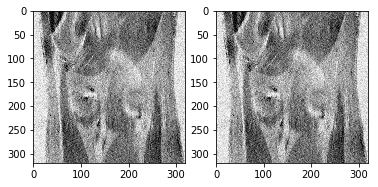

In [11]:
def generator(blurred_images, actual_images, batch_size):
    while True:
        counter  = 0 
        index_array = arr = np.arange(blurred_images.shape[0])
        np.random.shuffle(index_array)
        while counter<blurred_images.shape[0]:
            if blurred_images.shape[0]-counter<batch_size:
                break
            batch_masked_kspace = np.zeros((batch_size, 320, 320, 2))
            batch_original_kspace = np.zeros((batch_size, 320, 320, 2))
            batch_actual_images = np.zeros((batch_size,320,320,1))
            for i in range(batch_size):
                batch_masked_kspace[i,:,:,:] = imagetokspace(blurred_images[index_array[counter]])
                batch_original_kspace[i,:,:,:] = imagetokspace(actual_images[index_array[counter]])
                batch_actual_images[i,:,:] = np.abs(actual_images[index_array[counter]])
                counter +=1   
            yield batch_masked_kspace, [batch_original_kspace,batch_actual_images]
    
# creating generator
gen = generator(x_train, y_train, batch_size)


# sample data from generator
for ii in gen:
    plt.figure()
    plt.subplot(121)
    plt.imshow(ndimage.rotate(ii[1][1][10,:,:,0], -90),cmap = 'gray')
    plt.subplot(122)
    plt.imshow(ndimage.rotate(np.abs(np.fft.ifft2(ii[1][0][10,:,:,0] + 1j*ii[1][0][10,:,:,1])), -90),cmap = 'gray')
    plt.show()
    break

## Train model

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    hist = model.fit_generator(gen,
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs,
                               verbose=1,
                               validation_data = (mk_val,[ok_val, oi_val]),
                               callbacks=[checkpoint,earlyStopping,tbCallBack])

Epoch 1/50
1839/1839 [==============================] - 2158s 1s/step - loss: 0.0740 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.4855 - val_loss: 0.0716 - val_lambda_1_loss: 0.9999 - val_MSESSIM_loss: -0.4852
Epoch 2/50
1839/1839 [==============================] - 2124s 1s/step - loss: 0.0571 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.4930 - val_loss: 0.0720 - val_lambda_1_loss: 0.9999 - val_MSESSIM_loss: -0.4814
Epoch 3/50
1839/1839 [==============================] - 2126s 1s/step - loss: 0.0454 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.5089 - val_loss: 0.0695 - val_lambda_1_loss: 0.9999 - val_MSESSIM_loss: -0.4897
Epoch 4/50
1839/1839 [==============================] - 2126s 1s/step - loss: 0.0423 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.5132 - val_loss: 0.0751 - val_lambda_1_loss: 0.9999 - val_MSESSIM_loss: -0.4892
Epoch 5/50
1839/1839 [==============================] - 2124s 1s/step - loss: 0.0399 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.5167 - val_loss: 0.0669 - val_lambda_1_l

## Loading Model (MSE and SSIM)

In [6]:
import tensorflow as tf
from keras import backend as K

epochs = 50
batch_size= 16
model = etem.ete(stats[0],stats[1],stats[2],stats[3],kshape = (5,5),kshape2=(3,3))
opt = Adam(lr=1e-3,decay = 1e-7)
model.compile(loss = [etem.nrmse,etem.nrmse,etem.ssimloss],optimizer=opt, loss_weights=[0.02, 0.80, 0.18])

tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./summary_MSE_SSIM', histogram_freq=0, write_graph=True, write_images=True)

model_name = "end_to_end_MSE_SSIM.hdf5"
if os.path.isfile(model_name):
    print("loading weight")
    model.load_weights(model_name)

print(model.summary())

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

loading weight
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 48) 2448        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 48) 57648       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 320, 320, 48) 57648       conv2d_2[0][0]                   
______________________________________________________________________________________________

In [7]:
model.metrics_names

['loss', 'lambda_1_loss', 'MSESSIM_loss', 'MSESSIM_loss']

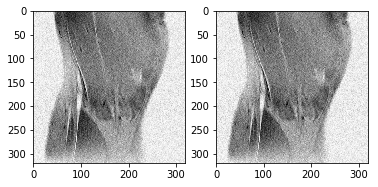

In [14]:
def generator(blurred_images, actual_images, batch_size):
    while True:
        counter  = 0 
        index_array = arr = np.arange(blurred_images.shape[0])
        np.random.shuffle(index_array)
        while counter<blurred_images.shape[0]:
            if blurred_images.shape[0]-counter<batch_size:
                break
            batch_masked_kspace = np.zeros((batch_size, 320, 320, 2))
            batch_original_kspace = np.zeros((batch_size, 320, 320, 2))
            batch_actual_images = np.zeros((batch_size,320,320,1))
            for i in range(batch_size):
                batch_masked_kspace[i,:,:,:] = imagetokspace(blurred_images[index_array[counter]])
                batch_original_kspace[i,:,:,:] = imagetokspace(actual_images[index_array[counter]])
                batch_actual_images[i,:,:] = np.abs(actual_images[index_array[counter]])
                counter +=1   
            yield batch_masked_kspace, [batch_original_kspace,batch_actual_images,batch_actual_images]
    
# creating generator
gen = generator(x_train, y_train, batch_size)


# sample data from generator
for ii in gen:
    plt.figure()
    plt.subplot(121)
    plt.imshow(ndimage.rotate(ii[1][1][10,:,:,0], -90),cmap = 'gray')
    plt.subplot(122)
    plt.imshow(ndimage.rotate(np.abs(np.fft.ifft2(ii[1][0][10,:,:,0] + 1j*ii[1][0][10,:,:,1])), -90),cmap = 'gray')
    plt.show()
    break

## Train model

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    hist = model.fit_generator(gen,
                               steps_per_epoch=x_train.shape[0] // batch_size,
                               epochs=epochs,
                               verbose=1,
                               validation_data = (mk_val,[ok_val, oi_val, oi_val]),
                               callbacks=[checkpoint,earlyStopping,tbCallBack])

Epoch 1/50
1839/1839 [==============================] - 2156s 1s/step - loss: 1.7390 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.4711 - val_loss: 0.4650 - val_lambda_1_loss: 0.9999 - val_MSESSIM_loss: -0.4667
Epoch 2/50
1839/1839 [==============================] - 2131s 1s/step - loss: 0.2700 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.4832 - val_loss: 0.1626 - val_lambda_1_loss: 0.9999 - val_MSESSIM_loss: -0.4682
Epoch 3/50
1839/1839 [==============================] - 2124s 1s/step - loss: 0.1169 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.4858 - val_loss: 0.0990 - val_lambda_1_loss: 0.9999 - val_MSESSIM_loss: -0.4706
Epoch 4/50
1839/1839 [==============================] - 2131s 1s/step - loss: 0.0851 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.4852 - val_loss: 0.0863 - val_lambda_1_loss: 0.9999 - val_MSESSIM_loss: -0.4620
Epoch 5/50
1839/1839 [==============================] - 2126s 1s/step - loss: 0.0779 - lambda_1_loss: 0.9999 - MSESSIM_loss: -0.4850 - val_loss: 0.0816 - val_lambda_1_l

KeyboardInterrupt: 